In [1]:
import g2o
import scipy
import numpy as np
import matplotlib.pyplot as plt

from optimizer import PoseGraphOptimization
from parse import get_dataset
from icp import icp

In [2]:
thres = 0.15
lc_num = 0
name = 'intel'

max_x = -float('inf')
max_y = -float('inf')
min_x = float('inf')
min_y = float('inf')

odoms_laser_file = 'data/' + name + "_odoms_laser.npy"
lasers_file = 'data/' + name + "_lasers.npy"
ipc_ts_file = 'data/' + name + "_ipc_ts.npy"
logger_ts_file = 'data/' + name + "_logger_ts.npy"
odoms_laser = np.load(odoms_laser_file)
lasers = np.load(lasers_file)
ipc_ts = np.load(ipc_ts_file)
logger_ts = np.load(logger_ts_file)

graph_optimizer = PoseGraphOptimization()
pose = np.eye(3)
id = 0
graph_optimizer.add_vertex(id, g2o.SE2(g2o.Isometry2d(pose)), fixed=True)

init_pose = np.eye(3)
vertex_idx = 1
registered_lasers = []
registered_idxs = []
registered_lasers.append(lasers[0])
registered_idxs.append(0)
vertex_id_odom_idx = []

# add odom to graph
id_list = []
for odom_idx, odom in enumerate(odoms_laser):
    if odom_idx==2500:
        break
    if odom_idx==0:
        prev_odom = odom[odom_idx].copy()
        prev_idx = 0
        continue

    do = odom - prev_odom
    if np.linalg.norm(do[:2])>0.4 or abs(do[2])>0.2:

        # (2, 180)
        A = lasers[prev_idx]
        B = lasers[odom_idx]
        registered_lasers.append(B)
        registered_idxs.append(odom_idx)
        dx, dy, dtheta = do[0], do[1], do[2]
        init_pose = np.array([[np.cos(dtheta), -np.sin(dtheta), dx], [np.sin(dtheta), np.cos(dtheta), dy],[0, 0, 1]])
        with np.errstate(all='raise'):
            try:
                T, distances, iterations,information = icp(B.T, A.T, init_pose, max_iterations=80, tolerance=0.0001)


            except Exception as e:
                print(odom_idx, e, A.shape, B.shape)
                assert 1==0
                continue

        pose = np.matmul(pose, T)
        graph_optimizer.add_vertex(vertex_idx, g2o.SE2(g2o.Isometry2d(pose)))
        vertex_id_odom_idx.append(odom_idx)

        rk = g2o.RobustKernelDCS()

        graph_optimizer.add_edge([vertex_idx-1, vertex_idx],
                                 g2o.SE2(g2o.Isometry2d(T)),
                                 information, robust_kernel=rk)

        prev_odom = odom
        prev_idx = odom_idx

        # loop closure
        if vertex_idx > 10 and not vertex_idx % 10:
            poses = [graph_optimizer.get_pose(idx).to_vector()[:2] for idx in range(vertex_idx-1)]

            kd = scipy.spatial.cKDTree(poses)
            x, y, theta = graph_optimizer.get_pose(vertex_idx).to_vector()
            direction = np.array([np.cos(theta), np.sin(theta)])
            idxs = kd.query_ball_point(np.array([x,y]), r=4.25, p=2.)
            for idx in idxs:
                A = registered_lasers[idx]
                with np.errstate(all='raise'):
                    try:
                        T, distances, iterations, information = icp(A.T, B.T, np.eye(3), max_iterations=80, tolerance=0.0001)

                    except Exception as e:
                        print(odom_idx, e, A.shape, B.shape)
                        continue

                if np.mean(distances) < thres:
                    dist = np.linalg.norm(T[:2,2])
                    print(odom_idx, vertex_idx, lc_num, dist, "added an edge")
                    lc_num+=1

                    # information = np.eye(3)
                    rk = g2o.RobustKernelDCS()
                    graph_optimizer.add_edge([vertex_idx, idx], g2o.SE2(g2o.Isometry2d(T)), information, robust_kernel=rk)

            graph_optimizer.optimize()
            pose = graph_optimizer.get_pose(vertex_idx).to_isometry().matrix()

        vertex_idx+=1

290 30 0 0.3343639874535775 added an edge
290 30 1 0.2714941338117957 added an edge
290 30 2 0.18690658459643966 added an edge
290 30 3 0.15590532563495646 added an edge
290 30 4 0.1719612315722028 added an edge
290 30 5 0.1535100144254976 added an edge
290 30 6 0.08587649062186609 added an edge
670 80 7 0.26214506772589685 added an edge
913 110 8 0.07434613864397928 added an edge
972 120 9 0.3255826531204507 added an edge
1042 130 10 0.3631313383088991 added an edge
1486 190 11 0.2882868358639616 added an edge
1486 190 12 0.2951977189392477 added an edge
1486 190 13 0.32559460561911624 added an edge
1704 220 14 0.07320410693984024 added an edge
1839 240 15 0.5204444130767628 added an edge
1839 240 16 0.9773279290997768 added an edge
1839 240 17 0.44336909246157225 added an edge
1839 240 18 1.0151609032649727 added an edge
1839 240 19 0.7114058219504659 added an edge
1839 240 20 0.6489685105058455 added an edge
1874 250 21 0.1231538059441463 added an edge
1902 260 22 0.9720708593763528

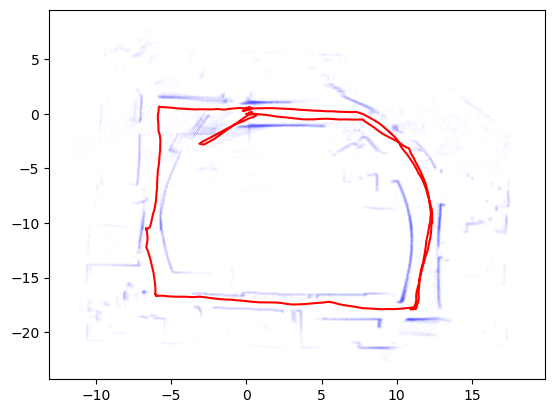

In [3]:
graph_optimizer.plot(num_vertex=vertex_idx, registered_lasers=registered_lasers, show_point_cloud=True)

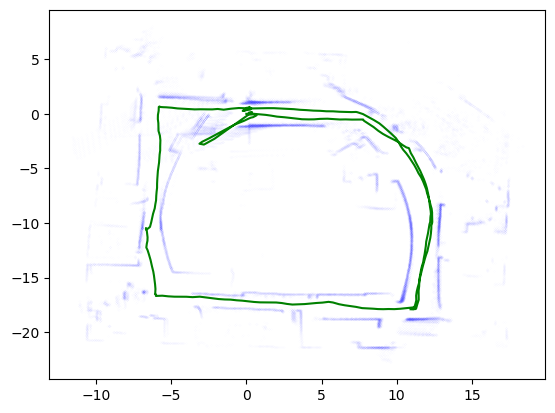

In [4]:
traj = [] # TODO: Print graph every X optimization to see patterns
point_cloud = []

for idx in range(vertex_idx):
    traj.append(graph_optimizer.get_pose(idx).to_vector()[:2])

    x = graph_optimizer.get_pose(idx)
    r = x.to_isometry().R
    t = x.to_isometry().t
    filtered = registered_lasers[idx].T
    filtered = filtered[np.linalg.norm(filtered, axis=1) < 80]
    point_cloud.append((r @ filtered.T + t[:, np.newaxis]).T)

point_cloud = np.vstack(point_cloud)

# Point cloud
xyreso = 0.01 # Map resolution (m)
point_cloud = (point_cloud / xyreso).astype('int')
point_cloud = np.unique(point_cloud, axis=0)
point_cloud = point_cloud * xyreso

# Trajectory
traj = np.array(traj)

# Plot
plt.plot(point_cloud[:, 0], point_cloud[:, 1], '.b', markersize=0.01)
plt.plot(traj[:, 0], traj[:, 1], '-g')
plt.show()